# Artificial Neural Networks and Deep Learning

---

## Homework 1


## 🌐 Connect Colab to Google Drive

In [ ]:
from google.colab import drive
drive.flush_and_unmount()

drive.mount('/gdrive', force_remount=True)
%cd /gdrive/My Drive/[2024-2025] AN2DL/Homework 1

Drive not mounted, so nothing to flush and unmount.
Mounted at /gdrive
/gdrive/My Drive/[2024-2025] AN2DL/Homework 1


## ⚙️ Import Libraries

In [ ]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras import models as tfkm

from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#extra imports
import math
from sklearn.model_selection import train_test_split, KFold
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image

seed = 42

np.random.seed(seed)
tf.random.set_seed(seed);

# Support Functions


### Removing high contrast images (red, blue)



In [ ]:
from collections import Counter

def calculate_edge_averages(image, frame_depth=10):
    """Calculate the average pixel values for the edge frame of a specified depth in each channel."""
    R, G, B = image[:, :, 0], image[:, :, 1], image[:, :, 2]
    channels = [R, G, B]

    edge_averages = []
    for channel in channels:
        # Extract edge regions within the frame depth
        top_edge = channel[:frame_depth, :]                # Top rows
        bottom_edge = channel[-frame_depth:, :]            # Bottom rows
        left_edge = channel[:, :frame_depth]               # Left columns
        right_edge = channel[:, -frame_depth:]             # Right columns

        # Combine all edge regions
        edge_pixels = np.concatenate((top_edge.flatten(), bottom_edge.flatten(),
                                      left_edge.flatten(), right_edge.flatten()))

        # Calculate the mean of the edge pixels
        edge_average = np.mean(edge_pixels)
        edge_averages.append(edge_average)

    return edge_averages

### making background black

To remove noise from images, background can be made black

In [ ]:
import cv2

# Define the function to make the background white with dual masks
def make_background_black(image, lower_purple=(105, 25, 25), upper_purple=(165, 255, 255), lower_red=(165, 70, 130), upper_red=(210,150,150)):
    # Convert the image to HSV color space
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    # Create a mask for purple color
    purple_mask = cv2.inRange(hsv_image, lower_purple, upper_purple)

    # Create a mask for red color (adjust this range if necessary)
    red_mask = cv2.inRange(hsv_image, lower_red, upper_red)

    # Combine both masks
    combined_mask = cv2.bitwise_or(purple_mask, red_mask)

    # Invert the mask to get the background
    background_mask = cv2.bitwise_not(combined_mask)

    # Convert the background of the image to white
    white_background = np.full_like(image, 0)  # Create a black image
    result_image = cv2.bitwise_and(image, image, mask=combined_mask)  # Keep only the selected color areas
    result_image = cv2.add(result_image, cv2.bitwise_and(white_background, white_background, mask=background_mask))  # Add white background

    return result_image

### Removing all black images from the dataset

In [ ]:
#make a functions that remove all black images from the dataset
def remove_black_images(images, labels):
  #removing images
  black_images = []
  black_indices = []
  for i in range(len(images)):
    image = images[i]
    if np.all(image == 0):
      black_images.append(image)
      black_indices.append(i)
  print(f"Number of black images: {len(black_images)}")
  images = np.delete(images, black_indices, axis=0)
  labels = np.delete(labels, black_indices, axis=0)

### Add rotated images

In [ ]:
def augment_with_rotations(images, labels):
    """
    Augments the dataset by adding three rotated versions of each image (90, 180, and 270 degrees).

    Args:
        images (numpy array): Array of images with shape (num_images, height, width, channels).
        labels (numpy array): Array of labels with shape (num_images,).

    Returns:
        augmented_images (numpy array): Augmented array of images with added rotations.
        augmented_labels (numpy array): Augmented array of labels.
    """
    # Initialize lists to hold the augmented images and labels
    augmented_images = []
    augmented_labels = []

    for i, img in enumerate(images):
        # Original image
        augmented_images.append(img)
        augmented_labels.append(labels[i])

        # 90 degrees rotation
        rotated_90 = np.rot90(img, k=1)
        augmented_images.append(rotated_90)
        augmented_labels.append(labels[i])

        # 180 degrees rotation
        rotated_180 = np.rot90(img, k=2)
        augmented_images.append(rotated_180)
        augmented_labels.append(labels[i])

        # 270 degrees rotation
        rotated_270 = np.rot90(img, k=3)
        augmented_images.append(rotated_270)
        augmented_labels.append(labels[i])

    # Convert lists to numpy arrays
    augmented_images = np.array(augmented_images)
    augmented_labels = np.array(augmented_labels)

    return augmented_images, augmented_labels

# Example usage
# augmented_images, augmented_labels = augment_with_rotations(images, labels)
# print(f"Original dataset size: {images.shape[0]}")
# print(f"Augmented dataset size: {augmented_images.shape[0]}")


### Add flipped images to the dataset

In [ ]:
#function for adding a flipped version of every image into the dataset
def add_flip_images(images, labels):
    # Initialize lists to hold the flipped images and labels
    flipped_images = []
    flipped_labels = []
    for i, img in enumerate(images):
        # Flip the image horizontallychat
        flipped_img = np.fliplr(img)
        flipped_images.append(flipped_img)
        flipped_labels.append(labels[i])
        # Append the flipped image and label to the lists
    flipped_images = np.array(flipped_images)
    flipped_labels = np.array(flipped_labels)
    return flipped_images, flipped_labels


### Cropping images

In [ ]:
# Crop function for a NumPy array, keeping the center
def crop_images(images, new_size):
    cropped_images = []
    for img in images:
        # Get the current size of the image
        height, width, _ = img.shape

        # Calculate the center of the image
        center_x, center_y = width // 2, height // 2

        # Calculate the cropping box
        crop_width, crop_height = new_size
        left = max(center_x - crop_width // 2, 0)
        upper = max(center_y - crop_height // 2, 0)
        right = min(center_x + crop_width // 2, width)
        lower = min(center_y + crop_height // 2, height)

        # Crop the image using NumPy slicing
        cropped_img = img[upper:lower, left:right]

        # Append the cropped image to the list
        cropped_images.append(cropped_img)

    return np.array(cropped_images)

## Transfer function

# Data Exploration

### Print data info

In [ ]:
def print_data_info(data):
  print("Keys in the .npz file:", data.files)
  for key in data.files:
    print(f"Array '{key}' - shape: {data[key].shape}, dtype: {data[key].dtype}")

  print("Number of label types, and count of elements in each label type")
  unique_labels, label_counts = np.unique(data['labels'], return_counts=True)
  print(dict(zip(unique_labels, label_counts)))

### Plot bar charts

In [ ]:
def plot_bar_chart(labels, label_counts):
  plt.bar(labels, label_counts)
  plt.xlabel('Label')
  plt.ylabel('Count')
  plt.title('Label Distribution')
  plt.show()

Noting that the data is unbalanced, possible solutions; image augmentation, rotating every image pi/2, pi, 3/2*pi and adding weights to the features in the training


### Display a random subsample of images




In [ ]:
def visualize_samples(images, labels, num_samples=5):
    unique_labels = np.unique(labels)
    plt.figure(figsize=(15, 15))
    for i, label in enumerate(unique_labels):
        idx = np.where(labels == label)[0]
        selected_images = np.random.choice(idx, num_samples, replace=False)
        for j, img_idx in enumerate(selected_images):
            plt.subplot(len(unique_labels), num_samples, i * num_samples + j + 1)
            plt.imshow(images[img_idx])
            plt.axis('off')
            plt.title(f"Class {label}")
    plt.show()


source: https://machinelearningmastery.com/best-practices-for-preparing-and-augmenting-image-data-for-convolutional-neural-networks/

### Visualize black images

In [ ]:
#Draw random samples and plot white images next to coloured images
def visualize_samples(images, white_images, labels, num_samples=5):
    unique_labels = np.unique(labels)
    plt.figure(figsize=(15, 15))

    for i, label in enumerate(unique_labels):
        # Select random samples for each label
        idx = np.where(labels == label)[0]
        selected_images = np.random.choice(idx, num_samples, replace=False)

        for j, img_idx in enumerate(selected_images):
            # Display original image
            plt.subplot(len(unique_labels), num_samples * 2, i * num_samples * 2 + j * 2 + 1)
            plt.imshow(images[img_idx])
            plt.axis('off')
            plt.title(f"Class {label} - Original")

            # Display white-background image next to it
            plt.subplot(len(unique_labels), num_samples * 2, i * num_samples * 2 + j * 2 + 2)
            plt.imshow(white_images[img_idx])
            plt.axis('off')
            plt.title(f"Class {label} - White BG")

    plt.tight_layout()
    plt.show()

# 🛠️ Train and Save the Model

### Loading data

In [ ]:
# Load the .npz file
data = np.load('training_set.npz')
images = data['images']
labels = data['labels']

# Remove duplicates
images, unique_indices = np.unique(images, axis=0, return_index=True)
labels = labels[unique_indices]

In [ ]:
## Printing data info
print_data_info(data)

NameError: name 'print_data_info' is not defined

In [ ]:
# Initialize lists to store the red and blue images and labels
red_images = []
red_labels = []
blue_images = []
blue_labels = []
blue_indices = []
gutta = 0
gutta2 = 0
gutta3 = 0
# Iterate over the images and classify based on red-blue difference
for i in range(len(images)):
    image = images[i]
    edge_averages = calculate_edge_averages(image)


    red_blue_difference = edge_averages[0] - edge_averages[2]

    if red_blue_difference > 10:
        # Append to red lists
        red_images.append(image)
        red_labels.append(labels[i])
        gutta3 = gutta3 + 1
    elif red_blue_difference < -10:
        # Append to blue lists
        blue_images.append(image)
        blue_labels.append(labels[i])
        blue_indices.append(i)
        gutta = gutta + 1
    else:
        # Append to blue lists by default if red-blue difference is in between
        blue_images.append(image)
        blue_labels.append(labels[i])
        blue_indices.append(i)
        gutta2 = gutta2 + 1

# Convert to numpy arrays if required by visualize_samples
red_images = np.array(red_images)
red_labels = np.array(red_labels)
blue_images = np.array(blue_images)
blue_labels = np.array(blue_labels)

print(f"gutta: {gutta}")
print(f"gutta2: {gutta2}")
print(f"gutta3: {gutta3}")
# Verify the counts
print(f"Number of red images: {len(red_images)}")
print(f"Number of blue images: {len(blue_images)}")
print(f"Number of total images: {len(images)}")

gutta: 0
gutta2: 0
gutta3: 11632
Number of red images: 11632
Number of blue images: 0
Number of total images: 11632


plotting red/blue images

In [ ]:
visualize_samples(blue_images, blue_labels, 10)
visualize_samples(red_images, red_labels, 10)

removing blue *images*

In [ ]:
images = np.delete(images, blue_indices, axis=0)
labels = np.delete(labels, blue_indices, axis=0)

count number of elements in each class

In [ ]:
unique_labels, label_counts = np.unique(labels, return_counts=True)
print(dict(zip(unique_labels, label_counts)))

{0: 822, 1: 2137, 2: 1056, 3: 1905, 4: 814, 5: 957, 6: 2298, 7: 1643}


### Data Pre processing

In [ ]:
# Normalizing the images
images = images / 255.0

# Split the data into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)
del images

# Adding rotated images to training set
augmented_images, augmented_labels = augment_with_rotations(X_train, y_train)
X_train = np.concatenate((X_train, augmented_images))
y_train = np.concatenate((y_train, augmented_labels))
del augmented_images


#add the flipped images
flipped_images, flipped_labels = add_flip_images(X_train, y_train)
X_train = np.concatenate((X_train, flipped_images))
y_train = np.concatenate((y_train, flipped_labels))
del flipped_images




Number of black images: 0


In [ ]:
unique_labels, label_counts = np.unique(y_train, return_counts=True)
print(dict(zip(unique_labels, label_counts)))

{0: 6610, 1: 17250, 2: 8320, 3: 15190, 4: 6470, 5: 7680, 6: 18320, 7: 13210}


### Getting variables

In [ ]:
#Uses a lot of memory to run
HEIGHT = X_train.shape[1]
WIDTH = X_train.shape[2]
CHANNELS = X_train.shape[3]
NUM_CLASSES = len(np.unique(y_train))

# Number of training epochs
epochs = 100

# Batch size for training
batch_size = 64

# Learning rate: step size for updating the model's weights
learning_rate = 0.001

# Print the defined parameters
print("Image Dimensions:", (HEIGHT, WIDTH, CHANNELS))
print("Number of Classes:", NUM_CLASSES)
print("Epochs:", epochs)
print("Batch Size:", batch_size)
print("Learning Rare:", learning_rate)

Image Dimensions: (96, 96, 3)
Number of Classes: 8
Epochs: 100
Batch Size: 64
Learning Rare: 0.001


### Transform to TF (OLD)

In [ ]:
#Transform to TF
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))

batch_size = 32
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

### Defining *weights*

In [ ]:
# Define the number of samples per class
class_counts = {0: 6610, 1: 17250, 2: 8320, 3: 15190, 4: 6470, 5: 7680, 6: 18320, 7: 13210}

# Get the unique classes and their counts
classes = np.array(list(class_counts.keys()))
counts = np.array(list(class_counts.values()))

# Calculate class weights
total_samples = sum(counts)
class_weights = {i: total_samples / (len(class_counts) * count) for i, count in class_counts.items()}

### Model definition

In [ ]:
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras import regularizers


def build_model(
    input_shape=(HEIGHT, WIDTH, CHANNELS),
    output_shape=NUM_CLASSES,
    learning_rate=learning_rate,
    seed=seed
):
    tf.random.set_seed(seed)
    l2_reg = 0.00

    # Load MobileNetV3Small as the base model
    base_model = MobileNetV3Small(
        input_shape=input_shape,
        include_top=False,  # Exclude the classification head
        weights='imagenet'  # Load pre-trained ImageNet weights
    )

    # Freeze the base model to prevent training its pre-trained weights
    base_model.trainable = False

    # Add custom classification head
    inputs = tfkl.Input(shape=input_shape, name='Input')
    x = base_model(inputs, training=False)  # Pass input through base model
    x = tfkl.GlobalAveragePooling2D(name='global_avg_pool')(x)  # Pool features
    x = tfkl.Dense(128, activation='relu', name='dense_1',)(x)   # First dense layer
    x = tfkl.Dropout(0.3, seed=seed, name='dropout_1')(x)       # Dropout for regularization

    outputs = tfkl.Dense(units=output_shape, activation='softmax', name='output')(x)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=inputs, outputs=outputs, name='CNN')

    # Compile the model
    loss = tfk.losses.SparseCategoricalCrossentropy()
    optimizer = tfk.optimizers.Adam(learning_rate)
    metrics = ['accuracy']
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

    # Return the model
    return model



### Building the model

Model: "CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                        ┃ Output Shape                 ┃       Param # ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ Input (InputLayer)                  │ (None, 96, 96, 3)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ MobileNetV3Small (Functional)       │ (None, 3, 3, 576)            │       939,120 │    N    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ input_layer_13 (InputLayer)    │ (None, 96, 96, 3)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ rescaling_13 (Rescaling)       │ (None, 96, 96, 3)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ conv (Conv2D)                  │ (None, 48, 48, 16)           │           432 │    N    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ conv_bn (BatchNormalization)   │ (None, 48, 48, 16)           │            64 │    N    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ activation_234 (Activation)    │ (None, 48, 48, 16)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ expanded_conv_depthwise_pad    │ (None, 49, 49, 16)           │             0 │    -    │
│ (ZeroPadding2D)                     │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ expanded_conv_depthwise        │ (None, 24, 24, 16)           │           144 │    N    │
│ (DepthwiseConv2D)                   │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ expanded_conv_depthwise_bn     │ (None, 24, 24, 16)           │            64 │    N    │
│ (BatchNormalization)                │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ re_lu_182 (ReLU)               │ (None, 24, 24, 16)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └                                │ (None, 1, 1, 16)             │             0 │    -    │
│ expanded_conv_squeeze_excite_avg_p… │                              │               │         │
│ (GlobalAveragePooling2D)            │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └                                │ (None, 1, 1, 8)              │           136 │    N    │
│ expanded_conv_squeeze_excite_conv   │                              │               │         │
│ (Conv2D)                            │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └                                │ (None, 1, 1, 8)              │             0 │    -    │
│ expanded_conv_squeeze_excite_relu   │                              │               │         │
│ (ReLU)                              │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └                                │ (None, 1, 1, 16)             │           144 │    N    │
│ expanded_conv_squeeze

 Total params: 1,014,008 (3.87 MB)

 Trainable params: 74,888 (292.53 KB)

 Non-trainable params: 939,120 (3.58 MB)

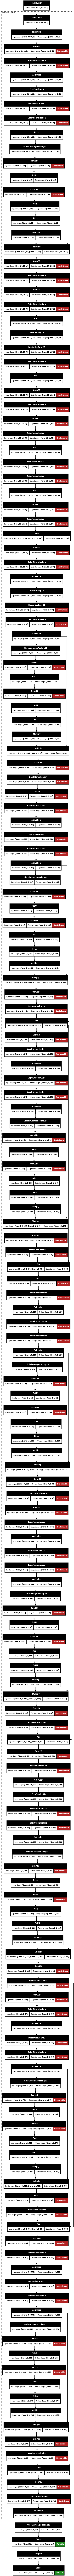

In [ ]:
# Build the model with specified input and output shapes
model = build_model()

# Display a summary of the model architecture
model.summary(expand_nested=True, show_trainable=True)

# Plot the model architecture
tfk.utils.plot_model(model, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

### Training the model

In [ ]:
# Define the patience value for early stopping
patience = 10

# Create an EarlyStopping callback
early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=patience,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,  # Reduce learning rate by half
    patience=3,  # After 3 epochs of no improvement
    min_lr=1e-6  # Set a minimum learning rate
)

# Store the callback in a list
callbacks = [early_stopping, reduce_lr]

In [ ]:
# Train the model with early stopping callback
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    class_weight=class_weights
).history

# Calculate and print the final validation accuracy
final_val_accuracy = round(max(history['val_accuracy'])* 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'weights.keras'
model.save(model_filename)

# Delete the model to free up resources
del model

Epoch 1/100
727/727 ━━━━━━━━━━━━━━━━━━━━ 32s 28ms/step - accuracy: 0.2958 - loss: 1.7783 - val_accuracy: 0.4994 - val_loss: 1.2644 - learning_rate: 0.0010
Epoch 2/100
727/727 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.4898 - loss: 1.2585 - val_accuracy: 0.5398 - val_loss: 1.1430 - learning_rate: 0.0010
Epoch 3/100
727/727 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.5309 - loss: 1.1605 - val_accuracy: 0.5604 - val_loss: 1.1095 - learning_rate: 0.0010
Epoch 4/100
727/727 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.5545 - loss: 1.1119 - val_accuracy: 0.6098 - val_loss: 1.0609 - learning_rate: 0.0010
Epoch 5/100
727/727 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.5702 - loss: 1.0703 - val_accuracy: 0.6468 - val_loss: 1.0063 - learning_rate: 0.0010
Epoch 6/100
727/727 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.5942 - loss: 1.0297 - val_accuracy: 0.6592 - val_loss: 0.9672 - learning_rate: 0.0010
Epoch 7/100
727/727 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.6072 - loss: 

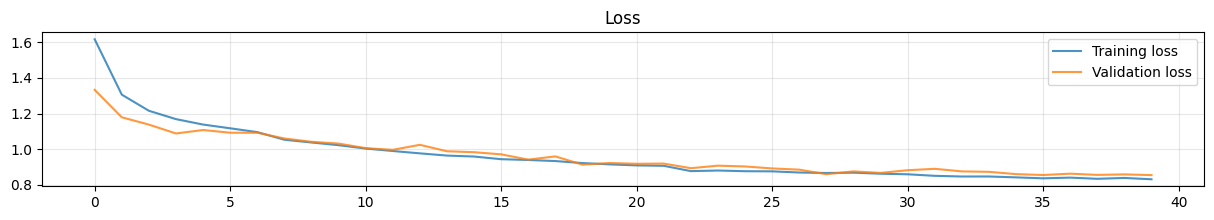

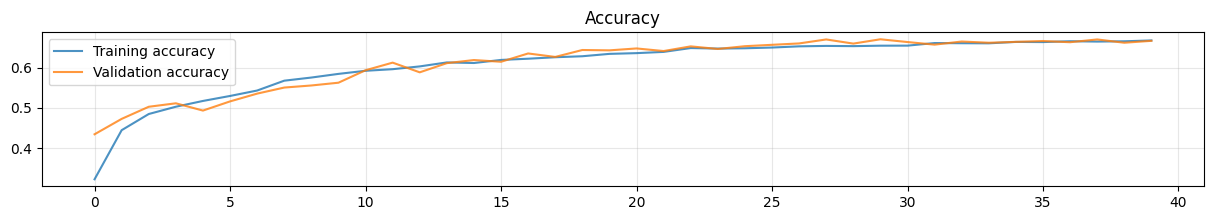

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(15, 2))
plt.plot(history['loss'], label='Training loss', alpha=.8)
plt.plot(history['val_loss'], label='Validation loss', alpha=.8)
plt.title('Loss')
plt.legend()
plt.grid(alpha=.3)

# Plot training and validation accuracy
plt.figure(figsize=(15, 2))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8)
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.8)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

### Idk hva dette er

In [ ]:
def extract_activations(model, X, num_images):

    # Identify the first convolutional layer
    first_conv_index = None
    for i, layer in enumerate(model.layers):
        if isinstance(layer, tfk.layers.Conv2D):
            first_conv_index = i
            break

    if first_conv_index is None:
        raise ValueError("The model does not contain a 2D convolution")

    # Extract activations from the first convolutional layer
    first_conv = tfk.Sequential(model.layers[:first_conv_index + 1])
    first_activations = first_conv(X[:num_images])

    # Identify the first pooling layer after the first convolution
    pooling_index = None
    for i, layer in enumerate(model.layers[first_conv_index + 1:], start=first_conv_index + 1):
        if isinstance(layer, (tfk.layers.MaxPooling2D, tfk.layers.AveragePooling2D)):
            pooling_index = i
            break

    if pooling_index is None:
        raise ValueError("The model does not contain a 2D pooling operation after the first convolution")

    # Extract activations from the first convolution and the first pooling layer
    second_conv = tfk.Sequential(model.layers[:pooling_index + 1])
    second_activations = second_conv(X[:num_images])

    return first_activations, second_activations

def find_last_conv_layer(model):

    # Identify the last convolutional layer in the model
    for layer in reversed(model.layers):
        if isinstance(layer, tfk.layers.Conv2D):
            return layer.name
    raise ValueError("No Conv2D layer found in the model.")

def visualize(model, X, y, unique_labels, num_images=50, display_activations=True):

    # Extract activations from the model
    first_activations, second_activations = extract_activations(model, X, num_images)

    # Select a random image for prediction and visualisation
    image = np.random.randint(0, num_images)
    predictions = model.predict(np.expand_dims(X[image], axis=0), verbose=0)
    class_int = np.argmax(predictions[0])
    class_str = unique_labels[class_int]

    # Create figure layout for displaying the image and predictions
    fig = plt.figure(constrained_layout=True, figsize=(16, 4))
    gs = gridspec.GridSpec(1, 2, figure=fig, width_ratios=[1.5, 1.5], wspace=0)

    # Display the selected image with the true class
    ax1 = fig.add_subplot(gs[0])
    ax1.set_title(f"True class: {unique_labels[np.argmax(y[image])]}", loc='left')
    if X[image].shape[-1] == 1:
        ax1.imshow(np.squeeze(X[image]), cmap='bone', vmin=0., vmax=1.)
    else:
        ax1.imshow(np.squeeze(X[image]), vmin=0., vmax=1.)
    ax1.axis('off')

    # Display the prediction bar
    ax2 = fig.add_subplot(gs[1])
    ax2.barh(unique_labels, np.squeeze(predictions, axis=0), color=plt.get_cmap('tab10').colors)
    ax2.set_title(f"Predicted class: {class_str} (Confidence: {max(np.squeeze(predictions, axis=0)):.2f})", loc='left')
    ax2.grid(alpha=0.3)
    ax2.set_xlim(0.0, 1.0)

    plt.show()

    # Display activations if required
    if display_activations:
        # Visualise the activations from the first convolutional layer
        fig, axes = plt.subplots(1, 8, figsize=(16, 14))
        for i in range(8):
            ax = axes[i]
            ax.imshow(first_activations[image, :, :, i], cmap='bone', vmin=0., vmax=1.)
            ax.axis('off')
            if i == 0:
                ax.set_title('First convolution activations', loc='left')
        plt.tight_layout()
        plt.show()

        # Visualise the activations from the first pooling layer
        fig, axes = plt.subplots(2, 8, figsize=(16, 5))
        for i in range(16):
            ax = axes[i // 8, i % 8]
            ax.imshow(second_activations[image, :, :, i], cmap='bone', vmin=0., vmax=1.)
            ax.axis('off')
            if i == 0:
                ax.set_title('Second convolution activations', loc='left')
        plt.tight_layout()
        plt.show()

# Example usage
visualize(model, X_test, y_test, unique_labels, display_activations=True)

In [ ]:
# Predict labels for the entire test set
predictions = model.predict(X_test, verbose=0)

# Display the shape of the predictions
print("Predictions Shape:", predictions.shape)

In [ ]:
# Load the saved model
model = tfk.models.load_model('CIFAR10_CNN_69.92.keras')

# Display a summary of the model architecture
model.summary(expand_nested=True, show_trainable=True)

# Plot the model architecture
tfk.utils.plot_model(model, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

### Old Model

In [ ]:
model = tfkm.Sequential([
    tfkl.InputLayer(input_shape=(HEIGHT, WIDTH, CHANNELS)),  # Input shape
    tfkl.Conv2D(32, (3, 3), activation='relu'),  # First convolutional layer
    tfkl.MaxPooling2D((2, 2)),  # Pooling layer

    tfkl.Conv2D(64, (3, 3), activation='relu'),  # Second convolutional layer
    tfkl.MaxPooling2D((2, 2)),  # Pooling layer

    tfkl.Conv2D(128, (3, 3), activation='relu'),  # Third convolutional layer
    tfkl.MaxPooling2D((2, 2)),  # Pooling layer

    tfkl.Flatten(),  # Flatten the output from convolutional tfkl
    tfkl.Dense(128, activation='relu'),  # Fully connected layer

    tfkl.Dense(NUM_CLASSES, activation='softmax'),  # Output layer (softmax for multi-class classification)
  ])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

model.fit(train_dataset, epochs=10)

model.save('weights.keras')

#testing model on test-set
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.prefetch(tf.data.experimental.AUTOTUNE)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

del model

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 94, 94, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 47, 47, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 47, 47, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 20, 20, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,638,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 16)                  │           2,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 8)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,733,976 (6.61 MB)

 Trainable params: 1,733,976 (6.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1495/1495 ━━━━━━━━━━━━━━━━━━━━ 34s 13ms/step - accuracy: 0.4280 - loss: 4.3947
Epoch 2/10
1495/1495 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step - accuracy: 0.5704 - loss: 2.8323
Epoch 3/10
1495/1495 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - accuracy: 0.5986 - loss: 2.4656
Epoch 4/10
1495/1495 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step - accuracy: 0.5483 - loss: 3.4086
Epoch 5/10
1495/1495 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step - accuracy: 0.6243 - loss: 2.0225
Epoch 6/10
1495/1495 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step - accuracy: 0.6240 - loss: 1.9108
Epoch 7/10
1495/1495 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step - accuracy: 0.6338 - loss: 1.7909
Epoch 8/10
1495/1495 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step - accuracy: 0.6343 - loss: 1.8272
Epoch 9/10
1495/1495 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step - accuracy: 0.6430 - loss: 1.7072
Epoch 10/10
1495/1495 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step - accuracy: 0.6504 - loss: 1.5756
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9192 - loss: 1.5153
Test Loss: 1.409248471260

# 📊 Prepare Your Submission

To prepare your submission, create a `.zip` file that includes all the necessary code to run your model. It **must** include a `model.py` file with the following class:

```python
# file: model.py
class Model:
    def __init__(self):
        """Initialize the internal state of the model."""
        self.neural_network = tf.keras.models.load_model('weights.keras')



    def predict(self, X):
        """Return a numpy array with the labels corresponding to the input X."""
```

The next cell shows an example implementation of the `model.py` file, which includes loading model weights from the `weights.keras` file and conducting predictions on provided input data. The `.zip` file is created and downloaded in the last notebook cell.

❗ Feel free to modify the method implementations to better fit your specific requirements, but please ensure that the class name and method interfaces remain unchanged.

In [ ]:
%%writefile model.py
import numpy as np

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

import cv2

class Model:
    def __init__(self):
        """
        Initialize the internal state of the model. Note that the __init__
        method cannot accept any arguments.

        The following is an example loading the weights of a pre-trained
        model.
        """
        self.neural_network = tfk.models.load_model('weights.keras')


    def make_background_black(self, image, lower_purple=(105, 25, 25), upper_purple=(165, 255, 255),
                              lower_red=(165, 70, 130), upper_red=(210,150,150)):
        """
        Process an image to replace its background with white if it contains colors within the specified purple or red ranges.
        """
        # Ensure image is numpy array with correct type
        if isinstance(image, tf.Tensor):
            image = image.numpy()
        assert isinstance(image, np.ndarray), f"Expected numpy array, got {type(image)}"
        assert image.dtype == np.uint8, f"Expected uint8 data type, got {image.dtype}"

        print(f"Image dtype: {image.dtype}, Image shape: {image.shape}")

        # Convert RGB to HSV
        hsv_image = cv2.cvtColor(np.asarray(image), cv2.COLOR_RGB2HSV)

        # Create masks
        purple_mask = cv2.inRange(hsv_image, lower_purple, upper_purple)
        red_mask = cv2.inRange(hsv_image, lower_red, upper_red)
        combined_mask = cv2.bitwise_or(purple_mask, red_mask)
        background_mask = cv2.bitwise_not(combined_mask)

        white_background = np.full_like(image, 0)
        result_image = cv2.bitwise_and(image, image, mask=combined_mask)
        result_image = cv2.add(result_image, cv2.bitwise_and(white_background, white_background, mask=background_mask))

        return result_image




    def predict(self, X):
        """
        Predict the labels corresponding to the input X. Note that X is a numpy
        array of shape (n_samples, 96, 96, 3) and the output should be a numpy
        array of shape (n_samples,). Therefore, outputs must no be one-hot
        encoded.

        The following is an example of a prediction from the pre-trained model
        loaded in the __init__ method.

        """

        # Making background black
        X = np.array([self.make_background_black(image) for image in X])
        X = X / 255.0

        preds = self.neural_network.predict(X)
        if len(preds.shape) == 2:
            preds = np.argmax(preds, axis=1)
        return preds

Overwriting model.py


In [ ]:
from datetime import datetime
filename = f'submission_{datetime.now().strftime("%y%m%d_%H%M%S")}.zip'

# Add files to the zip command if needed
!zip {filename} model.py weights.keras

from google.colab import files
files.download(filename)

  adding: model.py (deflated 59%)
  adding: weights.keras (deflated 22%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>